In [ ]:
import os
import numpy as np
import pandas as pd

from copy import deepcopy
from tqdm.notebook import tqdm, trange

import PIL
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import seaborn as sns
from matplotlib import colors, pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# i'm using GoogleColab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Data reading, preparation and exploration

In [ ]:
# used this command to copy dataset to GoogleColab session
#! cp '/content/gdrive/MyDrive/Github/capstone-project/tomatoes.zip' .

In [ ]:
!unzip -q 'tomatoes.zip'

In [ ]:
root = './tomatoes'

In [ ]:
# function to make dataframe with two columns - name of the image file, its class
def make_dataframe(path):
    x_col = list()
    y_col = list()

    for subdirectory in os.listdir(root):
        for _, _, files in os.walk(os.path.join(root, subdirectory)):
            filenames = [('/').join([subdirectory, f]) for f in files]
            x_col.extend(filenames)
            y_col.extend([subdirectory] * len(filenames))
    print(f'{len(x_col)} images has been read')
    df = pd.DataFrame(data=zip(x_col, y_col), columns=['filename', 'class'])
    return df

# function to read single image with its filename
def read_image(filename, root=root):
    path = ('/').join([root, filename])
    return Image.open(path)

# function to get image size
def get_sizes(filename):
    img = read_image(filename)
    width, height = img.size
    return width, height

In [ ]:
df = make_dataframe(root)

776 images has been read


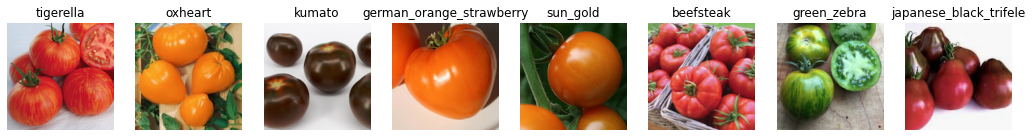

In [ ]:
# let'stake a look at some random images
n = 8
sample_df = df.sample(n=n, random_state=1)

fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(18, 6))
for i, (_, j) in enumerate(sample_df.iterrows()):
    ax[i].imshow(read_image(j['filename']))
    ax[i].set_title(j['class'])
    ax[i].axis('off')
plt.show()

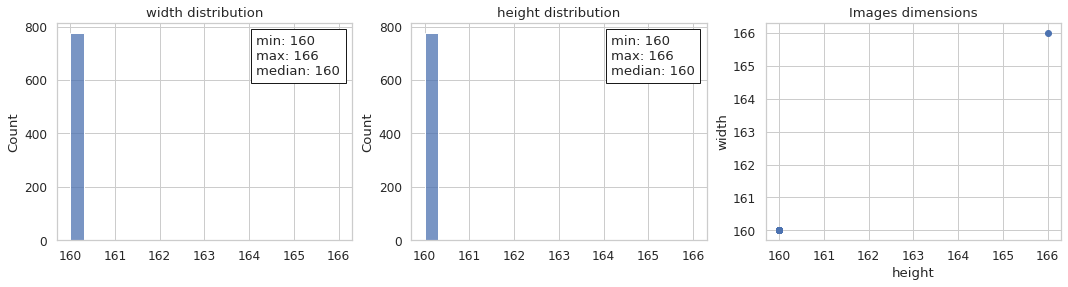

In [ ]:
# What sizes the images have?

from matplotlib.offsetbox import AnchoredText

sizes = [get_sizes(filename) for filename in df['filename']] 
W = np.array([i[0] for i in sizes])
H = np.array([i[1] for i in sizes])   

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(W, bins=20, ax=ax1)
sns.histplot(H, bins=20, ax=ax2)
ax1.set_title('width distribution')
ax2.set_title('height distribution')
ax3.scatter(H, W)
ax3.set_xlabel('height')
ax3.set_ylabel('width')
ax3.set_title('Images dimensions')
anchored_text_W = AnchoredText(f'min: {min(W)}\nmax: {max(W)}\nmedian: {int(np.median(W))}', loc=1)
anchored_text_H = AnchoredText(f'min: {min(H)}\nmax: {max(H)}\nmedian: {int(np.median(H))}', loc=1)
ax1.add_artist(anchored_text_W)
ax2.add_artist(anchored_text_H);

Images are of the same size (160, 160)

In [ ]:
NUM_CLASSES = df['class'].nunique()
print(f'There are {NUM_CLASSES} classes in dataset')

There are 15 classes in dataset


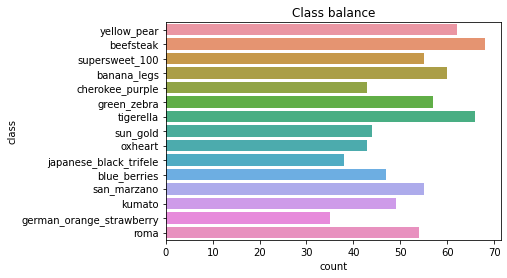

In [ ]:
# Checking the balance of the class in the dataset
sns.countplot(y="class", data=df)
plt.title('Class balance');

There are some classes with less counts, but dataset is almost balanced.

# Creating dataloaders

In [ ]:
# Stratified split
train_df, valid_df = train_test_split(df,
                                    test_size=0.2,
                                    shuffle=True,
                                    stratify=df['class'],
                                    random_state=0)

In [ ]:
# class weights for sampling
map_weights = 1 / train_df['class'].value_counts()
train_df['weight'] = train_df['class'].map(map_weights)

In [ ]:
def get_dataloaders(input_size, batch_size):
    # train dataloader with some augmentation
    train_gen = ImageDataGenerator(
                               rotation_range=20, # rotation
                               width_shift_range=0.2, # horizontal shift
                               height_shift_range=0.2, # vertical shift
                               zoom_range=0.2, # zoom
                               brightness_range = [0.6, 1.4], # brightness
                               horizontal_flip=True, # horizontal flip
                               preprocessing_function=preprocess_input)

    train_dataset = train_gen.flow_from_dataframe(train_df,
        root,
        weight_col = 'weight',
        target_size=input_size,
        shuffle=True,
        batch_size=batch_size)
    
    # validation dataloader
    valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    valid_dataset = valid_gen.flow_from_dataframe(valid_df,
        root,
        target_size=input_size,
        shuffle=False,
        batch_size=batch_size)
    
    return train_dataset, valid_dataset

In [ ]:
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32

In [ ]:
train_dataset, valid_dataset = get_dataloaders(TARGET_SIZE, BATCH_SIZE)

Found 620 validated image filenames belonging to 15 classes.
Found 156 validated image filenames belonging to 15 classes.


In [ ]:
class_names = list(train_dataset.class_indices.keys())

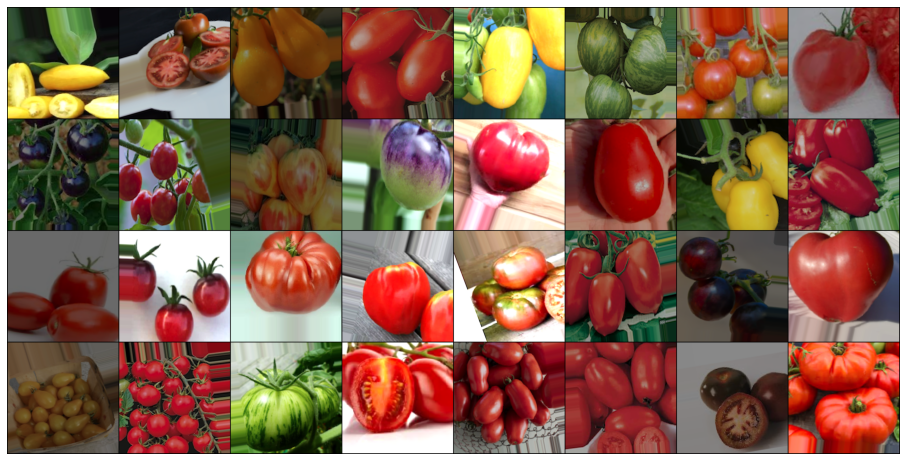

In [ ]:
from torchvision.utils import make_grid
import torch

batch = torch.tensor(next(iter(train_dataset))[0].transpose(0, 3, 1, 2) * 0.5 + 0.5)
plt.figure(figsize=(16, 16))
plt.imshow(make_grid(batch, nrow=8).permute(1, 2, 0))
plt.axis('off');

# Transfer learning model fune-tuning

In [ ]:
# Building model
def make_model(learning_rate=0.0001, size_inner=1024):

    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
    pooling='avg'
)

    base_model.trainable = False

    #########################################

    inputs = tf.keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    base = base_model(inputs, training=False)
    x = tf.keras.layers.Dense(size_inner, activation='relu')(base)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'],
        )
    
    return model

In [ ]:
# callbacks

# Learning rate scheduler
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5,
                                              patience=5, min_lr=0.0000001, cooldown=2)
# Overfitting detection with early stopping
early_stopping  = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15)

# saving checkpoint with best score
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max')

# Learning rate tuning

In [ ]:
scores = {}

for lr in [0.00001, 0.0001, 0.0005, 0.001, 0.01]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, verbose=0,
                        callbacks=[reduce_lr, early_stopping])
    scores[lr] = history.history
    print()

1e-05

0.0001

0.0005

0.001

0.01



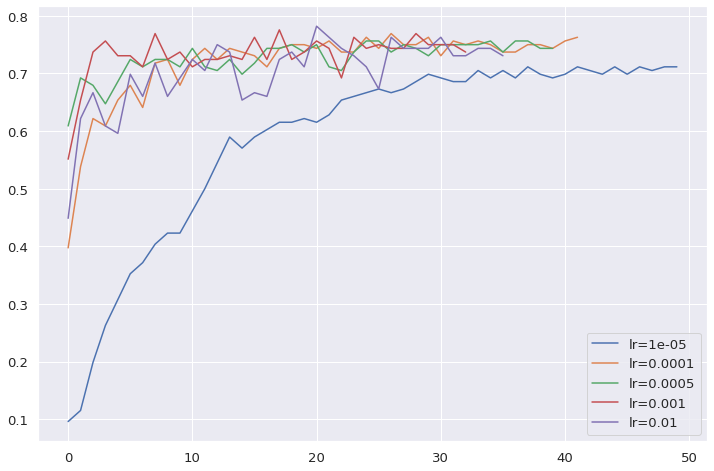

In [ ]:
sns.set(style="dark", font_scale=1.2)

plt.figure(figsize=(12, 8))
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=(f'lr={lr}'))

plt.legend()
plt.grid();

Values 0.00001 and 0.01 are not good options. Let's take lr=0.001. With input size (150, 150) model reached a bit more than 77% accuracy.

# Training model with larger input size

In [ ]:
size=1024
learning_rate = 0.0001

TARGET_SIZE = (299, 299)
BATCH_SIZE = 32

model = make_model(learning_rate=learning_rate, size_inner=size)

train_dataset, valid_dataset = get_dataloaders(TARGET_SIZE, BATCH_SIZE)

Found 620 validated image filenames belonging to 15 classes.
Found 156 validated image filenames belonging to 15 classes.


In [ ]:
model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_64 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_65 (Dense)            (None, 15)                15375     
                                                                 
Total params: 22,975,031
Trainable params: 2,113,551
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset,
                    callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.2435

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


20/20 [==============================] - 18s 792ms/step - loss: 0.0616 - accuracy: 0.2435 - val_loss: 2.2837 - val_accuracy: 0.5256 - lr: 1.0000e-04
Epoch 2/50
20/20 [==============================] - 15s 739ms/step - loss: 0.0509 - accuracy: 0.5919 - val_loss: 1.9188 - val_accuracy: 0.7372 - lr: 1.0000e-04
Epoch 3/50
20/20 [==============================] - 15s 735ms/step - loss: 0.0421 - accuracy: 0.6661 - val_loss: 1.6160 - val_accuracy: 0.7179 - lr: 1.0000e-04
Epoch 4/50
20/20 [==============================] - 15s 749ms/step - loss: 0.0355 - accuracy: 0.6887 - val_loss: 1.3765 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 5/50
20/20 [==============================] - 15s 725ms/step - loss: 0.0302 - accuracy: 0.7452 - val_loss: 1.2138 - val_accuracy: 0.7372 - lr: 1.0000e-04
Epoch 6/50
20/20 [==============================] - 15s 765ms/step - loss: 0.0261 - accuracy: 0.7871 - val_loss: 1.0896 - val_accuracy: 0.7692 - lr: 1.0000e-04
Epoch 7/50
20/20 [==============================] -

# Monitoring results

In [ ]:
# Calculate F1 score on validation data with best checkpoint
model = keras.models.load_model('xception.h5')

probs = model.predict(valid_dataset)
preds = np.argmax(probs, axis=1)
y_true = valid_dataset.classes

f1_score(y_true, preds, average='macro')

0.886456408400681

In [ ]:
# classification report
class_names = list(valid_dataset.class_indices.keys())
print(classification_report(y_true, preds, digits=3, zero_division=0, target_names=class_names))

                          precision    recall  f1-score   support

             banana_legs      1.000     0.833     0.909        12
               beefsteak      0.857     0.857     0.857        14
            blue_berries      0.818     1.000     0.900         9
         cherokee_purple      0.900     1.000     0.947         9
german_orange_strawberry      0.857     0.857     0.857         7
             green_zebra      1.000     1.000     1.000        11
  japanese_black_trifele      1.000     1.000     1.000         8
                  kumato      0.909     1.000     0.952        10
                 oxheart      0.750     0.667     0.706         9
                    roma      0.875     0.636     0.737        11
             san_marzano      0.909     0.909     0.909        11
                sun_gold      0.667     0.889     0.762         9
          supersweet_100      0.889     0.727     0.800        11
               tigerella      1.000     1.000     1.000        13
         

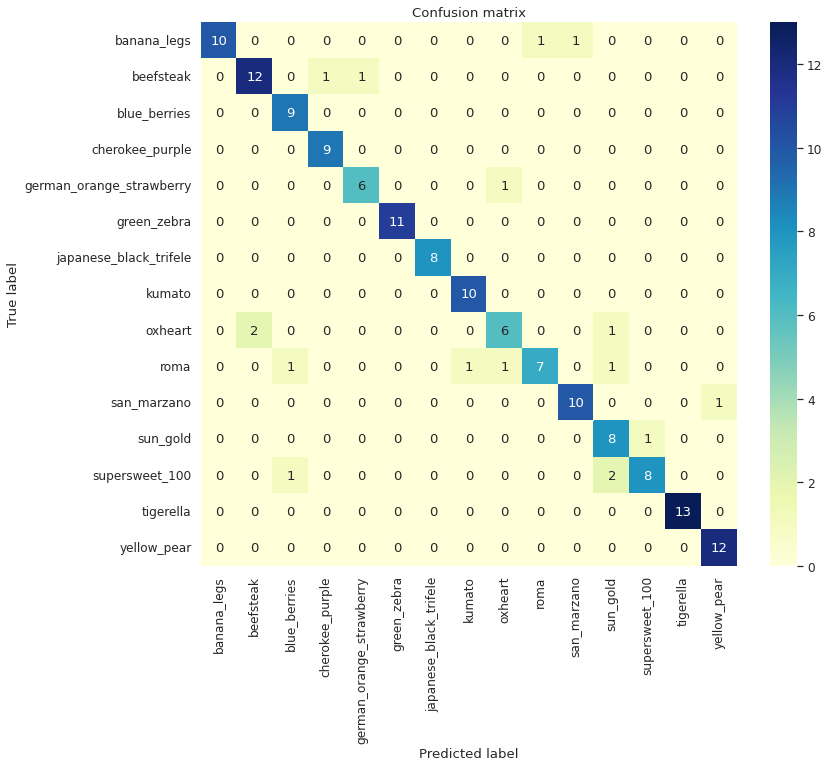

In [ ]:
# confusion matrix for validation set
sns.set(style="whitegrid", font_scale=1.1)
fig = plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_true, preds), 
            xticklabels=class_names, 
            yticklabels=class_names, 
            annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix');

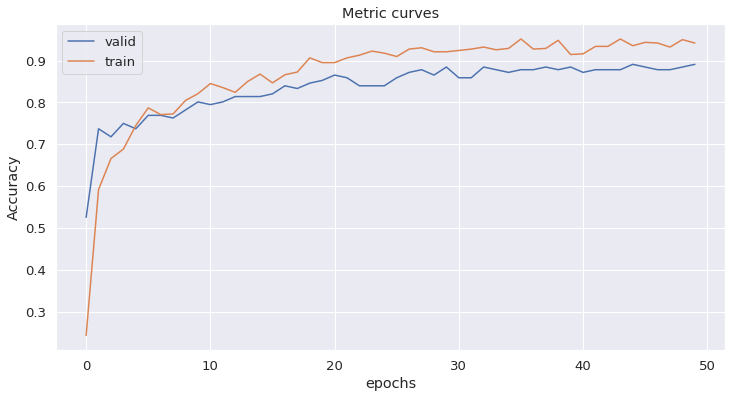

In [ ]:
sns.set(style="dark", font_scale=1.2)
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='valid')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.grid()
plt.title('Metric curves')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

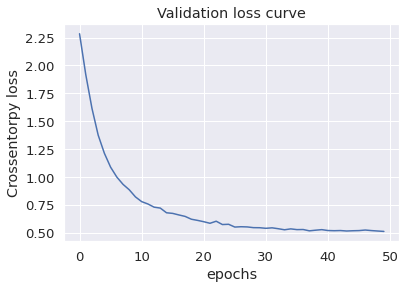

In [ ]:
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Validation loss curve')
plt.xlabel('epochs')
plt.ylabel('Crossentorpy loss');

In [ ]:
# visualize prediction
# Let's take a look at samples with not confident predictions (probability < 0.7 f.e.)
mask = np.all(probs <= 0.7, axis=1)
indices = np.arange(valid_dataset.samples)[mask]
img_list = valid_df.iloc[mask, 0].tolist()
labels_list = valid_df.iloc[mask, 1].tolist()

In [ ]:
from ipywidgets import interact, widgets
img_idx_slider = widgets.IntSlider(value=0, min=0, max=sum(mask)-1, description="Image index")

@interact(i=img_idx_slider)
def visualize_prediction(i=0):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
    img = read_image(img_list[i])
    ax1.imshow(img)
    ax1.set_title(f'{i} - True label: {labels_list[i]}')
    ax1.axis('off')
    ax2.barh(np.arange(0, NUM_CLASSES), probs[indices[i]], tick_label=class_names)
    ax2.set_title(f'Prediction: {class_names[preds[indices[i]]]}')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Labels')
    ax2.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.5)
    plt.xticks(rotation=90)
    fig.tight_layout()
    fig.show();

interactive(children=(IntSlider(value=0, description='Image index', max=56), Output()), _dom_classes=('widget-…

# Convert model to TFLite and test it with image from URL

In [ ]:
import tensorflow.lite as tflite

model = keras.models.load_model('xception.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpw1v5whlm/assets


In [ ]:
!wget https://cdn.shopify.com/s/files/1/0871/0950/products/beefsteakpic.jpg -O beefsteak.jpg

--2021-12-12 16:45:45--  https://cdn.shopify.com/s/files/1/0871/0950/products/beefsteakpic.jpg
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.1.12, 151.101.129.12, 151.101.193.12, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.1.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18402 (18K) [image/jpeg]
Saving to: ‘beefsteak.jpg’

beefsteak.jpg       100%[===================>]  17.97K  --.-KB/s    in 0s      

2021-12-12 16:45:45 (103 MB/s) - ‘beefsteak.jpg’ saved [18402/18402]



In [ ]:
img = load_img('beefsteak.jpg', target_size=(299, 299))

x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

In [ ]:
interpreter = tflite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']


interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [ ]:
class_names

['banana_legs',
 'beefsteak',
 'blue_berries',
 'cherokee_purple',
 'german_orange_strawberry',
 'green_zebra',
 'japanese_black_trifele',
 'kumato',
 'oxheart',
 'roma',
 'san_marzano',
 'sun_gold',
 'supersweet_100',
 'tigerella',
 'yellow_pear']

In [ ]:
dict(zip(class_names, preds[0]))

{'banana_legs': 6.088453e-05,
 'beefsteak': 0.7622923,
 'blue_berries': 3.3637745e-05,
 'cherokee_purple': 0.01738654,
 'german_orange_strawberry': 0.122414306,
 'green_zebra': 0.006195587,
 'japanese_black_trifele': 0.00060730625,
 'kumato': 0.00058466854,
 'oxheart': 0.08791665,
 'roma': 0.00062880595,
 'san_marzano': 0.00022218194,
 'sun_gold': 0.00012833446,
 'supersweet_100': 0.00018760857,
 'tigerella': 0.0012055489,
 'yellow_pear': 0.0001356364}

Model predicted image of tomato as *beefsteak* with probability 0.76, and that's correct!